Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [124]:
#%pip install scipy

In [125]:
#%pip install tensorflow-metal

In [126]:
#%pip install tensorflow-gpu

In [127]:
#%pip install matplotlib

In [128]:
#%pip install pandas

In [129]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [130]:
import tensorflow as tf
print(tf.__version__)

2.16.2


In [131]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL

from tensorflow.keras import layers, models
#from tensorflow.keras.models import Sequential

#from tensorflow.keras.layers import Normalization

from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
# from tensorflow.keras.layers import Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
import warnings

# Disable all warnings
warnings.filterwarnings("ignore")


In [132]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [133]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset

data_dir_train = pathlib.Path("../data/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('../data/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [134]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [135]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [136]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [137]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [138]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

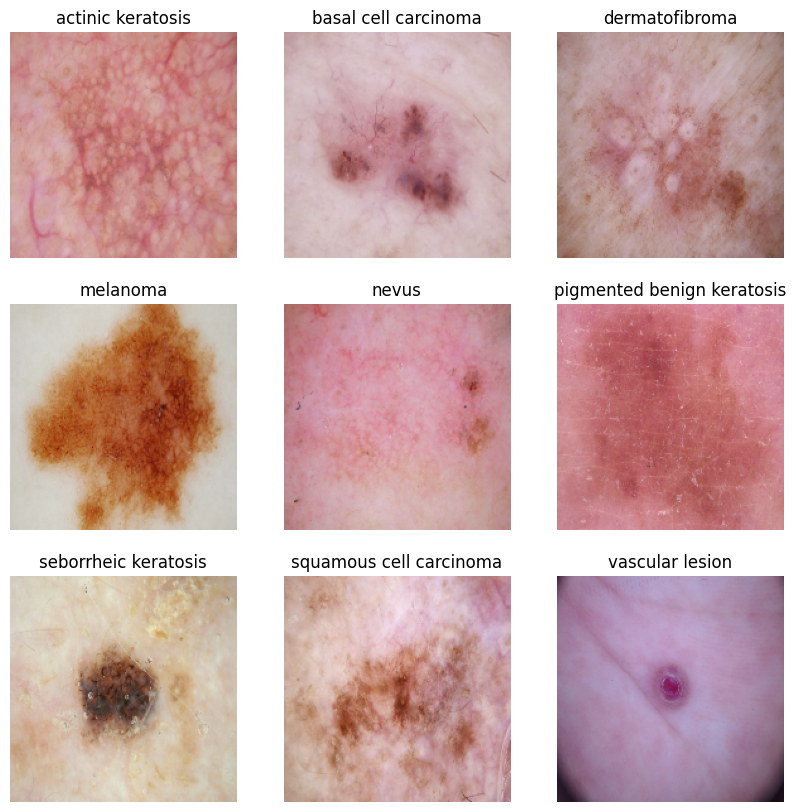

In [139]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
# Dictionary to store one image per class
class_images = {class_name: None for class_name in class_names}

# Iterate through the dataset to find one image per class
for images, labels in train_ds:
    for i in range(images.shape[0]):
        label = labels[i].numpy()
        class_name = class_names[label]
        if class_images[class_name] is None:
            class_images[class_name] = images[i].numpy()
        # Break if all classes have been found
        if all(img is not None for img in class_images.values()):
            break
    if all(img is not None for img in class_images.values()):
        break

# Plotting the images
plt.figure(figsize=(10, 10))
for idx, (class_name, image) in enumerate(class_images.items()):
    plt.subplot(3, 3, idx + 1)
    plt.title(class_name)
    plt.imshow(image.astype("uint8"))
    plt.axis("off")
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [140]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

We will use the following order to train our model:
Convolution → BatchNormalization → Activation (e.g., ReLU) → Pooling

Following are the advantages of doing batch normalization before calling activation function:
- **Improved Training Stability**: Normalizing the output of the convolutional layer before activation can help stabilize the training process.
- **Accelerated Convergence**: It often helps in faster convergence during training.
- **Mitigates Internal Covariate Shift**: By normalizing before applying the non-linearity, it reduces the issue of internal covariate shift more effectively.
- **Mean and Variance Impact**: BN adjusts the mean and variance of the convolutional layer's output, ensuring that the inputs to the activation function have a stable distribution

Standard architectures like Resnet and Inception follow this practice. However, specific use cases and datasets might benefit from experimenting with different placements. 

I will experiment based on the above method illustrated.

In [141]:
### Your code goes here
# Create the CNN model
model = models.Sequential([
    # Input layer to define the input shape
    layers.Input(shape=(img_height, img_width, 3)),
    
    # Rescaling layer to normalize pixel values
    layers.Rescaling(1./255),

    # First convolutional block
    layers.Conv2D(32, (3, 3), activation=None),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2)),

    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation=None),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2)),

    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation=None),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2)),

    # Fourth convolutional block
    layers.Conv2D(128, (3, 3), activation=None),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2)),

    # Flatten the feature maps before the fully connected layer
    layers.Flatten(),

    # Fully connected layer with dropout
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),

    # Output layer with 9 classes
    layers.Dense(9, activation='softmax')
])

model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_14 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 178, 178, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_56 (ReLU)                 │ (None, 178, 178, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_57          │ (None, 87, 87, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_57 (ReLU)                 │ (None, 87, 87, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_58          │ (None, 41, 41, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_58 (ReLU)                 │ (None, 41, 41, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_59          │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_59 (ReLU)                 │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 512)            │     5,308,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,555,785 (21.19 MB)

 Trainable params: 5,555,081 (21.19 MB)

 Non-trainable params: 704 (2.75 KB)

Batch normalization can be applied to convolutional layers and is typically inserted after the convolution operation but before the activation function. 
A typical convolutional block with batch normalization looks:
- Convolution Layer
- Batch Normalization
- Activation Function (e.g., ReLU)
- Pooling Layer (MaxPooling in above case)
- configure dropouts

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [142]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [143]:
# View the summary of all layers
model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_14 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 178, 178, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_56 (ReLU)                 │ (None, 178, 178, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_57          │ (None, 87, 87, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_57 (ReLU)                 │ (None, 87, 87, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_58          │ (None, 41, 41, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_58 (ReLU)                 │ (None, 41, 41, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_59          │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_59 (ReLU)                 │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 512)            │     5,308,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,555,785 (21.19 MB)

 Trainable params: 5,555,081 (21.19 MB)

 Non-trainable params: 704 (2.75 KB)

### Train the model

In [144]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - accuracy: 0.2447 - loss: 6.3531 - val_accuracy: 0.1521 - val_loss: 2.1673
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.3535 - loss: 1.7500 - val_accuracy: 0.2058 - val_loss: 2.1336
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.4137 - loss: 1.6372 - val_accuracy: 0.1499 - val_loss: 2.2659
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.4480 - loss: 1.5502 - val_accuracy: 0.1499 - val_loss: 2.3119
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.4553 - loss: 1.5095 - val_accuracy: 0.1588 - val_loss: 2.1800
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.4750 - loss: 1.4761 - val_accuracy: 0.1745 - val_loss: 2.3600
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.4984 - loss: 1.4064 - val_accuracy: 0.2640 - val_loss: 2.1196
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.4895 - loss: 1.4064 - val_accuracy: 0

### Visualizing training results

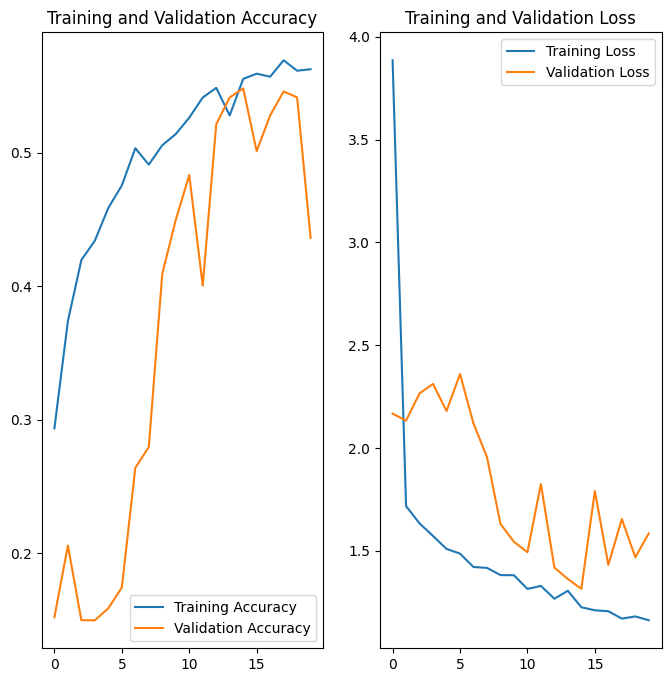

In [145]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [146]:
for i in range(len(acc)):
  print(f"Training accuracy: {history.history['accuracy'][i] * 100:.2f}%, validation accuracy: {history.history['val_accuracy'][i] * 100:.2f}%")    

Training accuracy: 29.35%, validation accuracy: 15.21%
Training accuracy: 37.39%, validation accuracy: 20.58%
Training accuracy: 41.96%, validation accuracy: 14.99%
Training accuracy: 43.42%, validation accuracy: 14.99%
Training accuracy: 45.87%, validation accuracy: 15.88%
Training accuracy: 47.54%, validation accuracy: 17.45%
Training accuracy: 50.33%, validation accuracy: 26.40%
Training accuracy: 49.11%, validation accuracy: 27.96%
Training accuracy: 50.56%, validation accuracy: 40.94%
Training accuracy: 51.40%, validation accuracy: 44.97%
Training accuracy: 52.62%, validation accuracy: 48.32%
Training accuracy: 54.13%, validation accuracy: 40.04%
Training accuracy: 54.85%, validation accuracy: 52.13%
Training accuracy: 52.79%, validation accuracy: 54.14%
Training accuracy: 55.52%, validation accuracy: 54.81%
Training accuracy: 55.92%, validation accuracy: 50.11%
Training accuracy: 55.69%, validation accuracy: 52.80%
Training accuracy: 56.92%, validation accuracy: 54.59%
Training a

#### Evaluating Model overfit or underfit

In [147]:
# Evaluate the model on the training and validation datasets
train_loss, train_acc = model.evaluate(train_ds)
val_loss, val_acc = model.evaluate(val_ds)

# Print the final accuracy scores
print(f"Final Training Accuracy: {train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {val_acc * 100:.2f}%")

# Check for overfitting or underfitting
if train_acc > val_acc and (train_acc - val_acc) > 0.05:
    print("The model is likely overfitting.")
elif val_acc > train_acc and (val_acc - train_acc) > 0.05:
    print("The model is likely underfitting.")
else:
    print("The model is performing well with no major overfitting or underfitting.")


56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4785 - loss: 1.4218
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4802 - loss: 1.5092
Final Training Accuracy: 47.32%
Final Validation Accuracy: 43.62%
The model is performing well with no major overfitting or underfitting.


We can see that with very high Training accuracy and Validation accuracy being less than threshold, we can believe that the model is very likely overfitting.

### Write your findings here

Thus we can clearly see that model is likely Overfitting and we need to chose right data augumentation strategy, we will use ImageDataGenerator

In [154]:
# Define the augmentation strategy
datagen = ImageDataGenerator(
    rotation_range=10, #Randomly rotates images within the specified range of degrees.
    zoom_range=0.1, #Randomly zooms inside images.
    width_shift_range=0.1, #Randomly shifts images horizontally by a fraction of the total width.
    height_shift_range=0.1, #Randomly shifts images vertically by a fraction of the total height.
    horizontal_flip=True, #Randomly flips images horizontally.
    vertical_flip=True, #Randomly flips images vertically.
    shear_range=0.2, #Shear angle in counter-clockwise direction in degrees.
    fill_mode='nearest', #see below details
    brightness_range=(0.8, 1.2), #Randomly changes the brightness of the images.
)
# The fill_mode='nearest' parameter in Keras' ImageDataGenerator specifies how to fill in new pixels that are created when an image is transformed (e.g., rotated or shifted). 
# It fills these pixels with the nearest pixel values from the original image, effectively extending the edges of the image to handle the transformation.

# Create a generator for training data
train_batches = datagen.flow_from_directory(
    data_dir_train,
    target_size=(180, 180),
    batch_size=64,
    class_mode='categorical'
)

valid_batches = datagen.flow_from_directory(
    data_dir_test,
    target_size=(180, 180),
    batch_size=64,
    class_mode='categorical'
)


Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


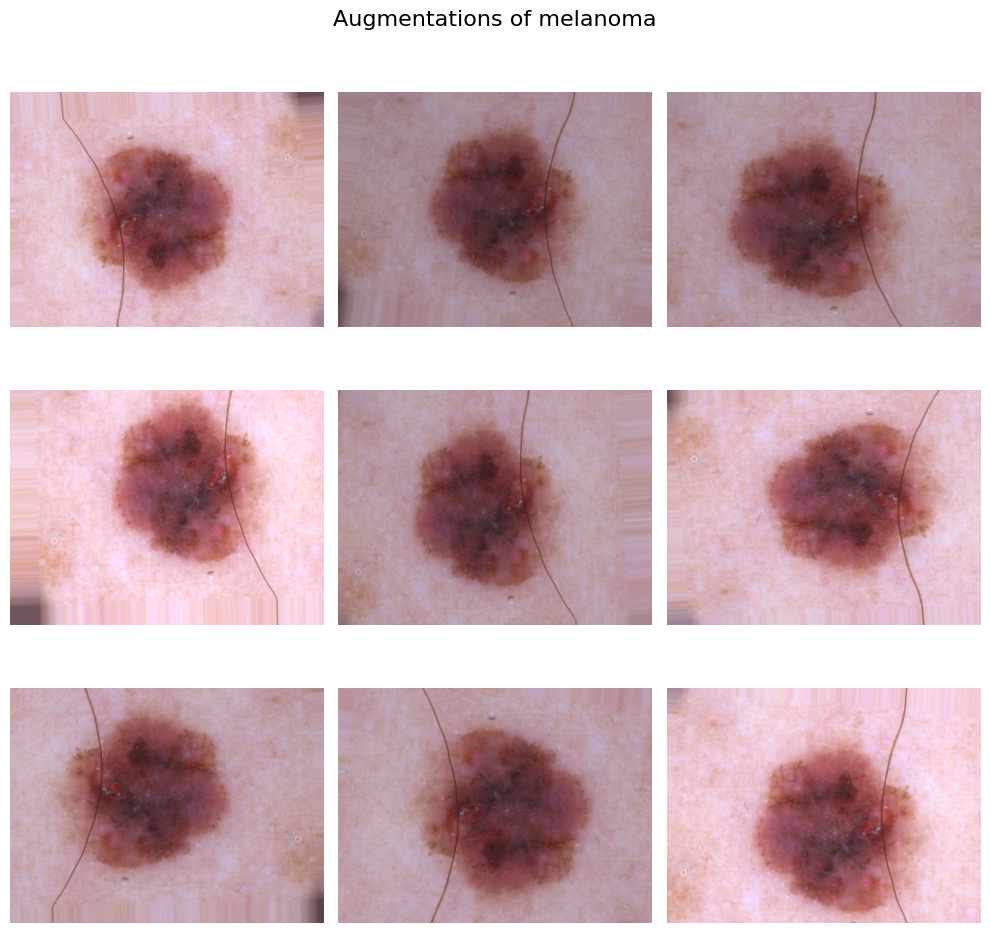

In [155]:
# Visualize the augmentation strategy for one instance of a training image
def visualize_augmentations(image_path, datagen, num_examples=9):
    img = load_img(image_path)  # Load the image
    img_array = img_to_array(img)  # Convert the image to a numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match the input shape required by ImageDataGenerator
    
    # Generate augmented images
    augmented_images = [datagen.flow(img_array, batch_size=1)[0][0].astype('uint8') for _ in range(num_examples)]
    
    # Plot the augmented images
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.flatten()
    for img, ax in zip(augmented_images, axes):
        ax.imshow(img)
        ax.axis('off')
    # Set the title with the directory name
    directory_name = os.path.basename(os.path.dirname(image_path))
    fig.suptitle(f'Augmentations of {directory_name}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Select a sample image from the training directory for visualization
sample_image_path = os.path.join(data_dir_train, 'melanoma', 'ISIC_0000139.jpg')
visualize_augmentations(sample_image_path, datagen)

### Todo:
### Create the model, compile and train the model


### Compiling the model

In [156]:
## Your code goes here
# Compile the model

# Define the Adam optimizer with specified parameters
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0, amsgrad=False)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])



### Training the model

The lr_schedule function reduces the learning rate by a factor of exp(-0.1) after 10 epochs.
ReduceLROnPlateau is a mthod for adjusting the learning rate during training. It reduces the learning rate when a metric has stopped improving, which can be very effective for training stability and convergence, especially when the model is struggling to improve.

This method is often more dynamic and responsive to the training process compared to a fixed schedule.

In [157]:
## Your code goes here, note: train your model for 20 epochs

# Learning rate reduction on plateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=0.00001, verbose=1)

# Fit the model
history = model.fit(
    train_batches,
    epochs=epochs,
    verbose = 1,
    validation_data=valid_batches,
    callbacks=[reduce_lr]
)

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 29s 628ms/step - accuracy: 0.5201 - loss: 1.4171 - val_accuracy: 0.2966 - val_loss: 3.2600 - learning_rate: 0.0010
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 532ms/step - accuracy: 0.5034 - loss: 1.3684 - val_accuracy: 0.2712 - val_loss: 3.1987 - learning_rate: 0.0010
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 535ms/step - accuracy: 0.5133 - loss: 1.3728 - val_accuracy: 0.2881 - val_loss: 4.9872 - learning_rate: 0.0010
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.5369 - loss: 1.3185
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 542ms/step - accuracy: 0.5363 - loss: 1.3198 - val_accuracy: 0.1949 - val_loss: 4.6691 - learning_rate: 0.0010
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 538ms/step - accuracy: 0.5238 - loss: 1.3349 - val_accuracy: 0.3475 - val_loss: 2.7254 - learning_rate: 5.0000e-04
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 23s 539ms/step - accuracy: 0.5359 - loss: 

### Visualizing the results

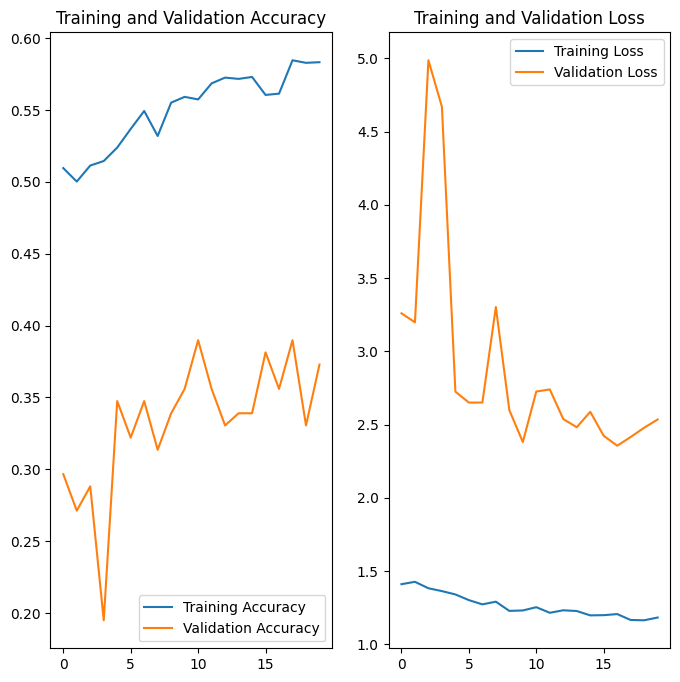

In [159]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [160]:
# Evaluate the model on the training and validation datasets
train_loss, train_acc = model.evaluate(train_batches)
val_loss, val_acc = model.evaluate(valid_batches)

# Print the final accuracy scores
print(f"Final Training Accuracy: {train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {val_acc * 100:.2f}%")

# Check for overfitting or underfitting
if train_acc > val_acc and (train_acc - val_acc) > 0.05:
    print("The model is likely overfitting.")
elif val_acc > train_acc and (val_acc - train_acc) > 0.05:
    print("The model is likely underfitting.")
else:
    print("The model is performing well with no major overfitting or underfitting.")

35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 488ms/step - accuracy: 0.5973 - loss: 1.0535
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.3614 - loss: 2.4255
Final Training Accuracy: 60.79%
Final Validation Accuracy: 33.90%
The model is likely overfitting.


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="To do"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here

#### **Todo:**  Train your model

In [ ]:
epochs = 30
## Your code goes here, use 50 epochs.
history = # your model fit code

#### **Todo:**  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

